# Time-lag correlation

The purpose of this notebook is to demonstrate the functionality of `time-lag`.

The demo is organised to show

- Step 1: The steps of calculating the vertical velocity variance

- Step 2: Correlations of vertical velocity variance and atmospheric data

Note that when you submit a pull request, you should `clear all outputs` from your python notebook for a cleaner merge.


In [1]:
import sys
sys.path.append('../')
from template_project import plotters, tools, utilities, writers, readers
import importlib

import pandas as pd
import numpy as np

# After editing your_module_name.py, reload it:
importlib.reload(plotters)

<module 'template_project.plotters' from 'c:\\Users\\m300892\\Documents\\PhD\\TERIFIC\\time-lag\\notebooks\\..\\template_project\\plotters.py'>

## Load data

In [2]:
# Load gliderdata of churchill (containing w, MLD from a density threshold (0.01) and MLD_manually selected)
ds                  = readers.read_glider('churchill')
# Load ERA5 datasets in the LabSea of years 2021/2022
ds_wind, ds_heat    = readers.read_ERA5()
# Load high pass filtered vertical velocity data from churchill
ds_hp               = readers.read_hp_w()

## Configuration

In [8]:

min_perc = 0.3          # Minimum percentage of data within the rolling window at most common resolution
outer_window_min = 60*6 # Outer window size in minutes
inner_window_min = 5    # Inner window size in minutes
resolution = 1          # Sampling resolution in seconds (needed to calc the minimum number of observations in a rolling window)
glidername= 'L1398'     # Name of the glider

config = {
    "rolling_window_outer"     : f"{outer_window_min}min",           # 6H choosen by Steffen
    "rolling_window_inner"     : f"{inner_window_min}min",           # 1H, choosen by steffen's
    "rolling_min_periods_outer": int(outer_window_min*min_perc*60),  # Minimum number of observations within the outer rolling window (data before: in hours or see inner window)
    "rolling_min_periods_inner": int((inner_window_min/60)*(3600*1/resolution)*min_perc),  # Minimum number of observations within the inner rolling window (data before: in seconds or see most common time difference)
    
    "var"               : 'w',
    "data_in"           : ds, 
    "data_wind"         : ds_wind,
    "data_heat"         : ds_heat,
    "start_time"        : pd.to_datetime('2022-03-01T00:00:00'), 
    "end_time"          : pd.to_datetime('2022-03-15T00:00:00'), 
    "interp_method"     : "linear",
    "depth_min"         : 50,  # Drop upper 50m (wave effects, etc.)
    "max_lag"           : 24 * 3,
    "freq"              : 'H',
    "add_ext_interp"    : False, #True,
    "variables_to_keep" : ['salinity', 'temperature', 'density', 'depth', 'latitude', 'longitude', 'time', 'MLD', 'w', 'profile_direction', 'MLD_manual', 'profile_index'], #if None it keeps the standard variables
}
# Preprocess data
ds_398                                                          = tools.preprocess_data(config)
# Interpolate ERA5 onto hourly positions of the glider
resample_time, series_wind, series_heat                         = tools.interpolate_onto_track(ds_398, config)

# Calculate vertical velocity variance
mld_var = 'MLD_manual' #or 'MLD'
series_w_prime, gap_mask, intermediates                         = tools.get_wprime_timeseries_update_3(resample_time,ds_398, config, debug=True, mld_var=mld_var) # max_gap_duration=np.timedelta64(1, "h"),
# Calculate vertical velocity variance masking just before the interpolation (thus including more values from outside the ML)
series_w_prime_masklater, _ , intermediates_mask_later          = tools.get_wprime_timeseries_update_2(resample_time,ds_398, config, debug=True, mld_var=mld_var)
# Calculate vertical velocity variance without any masking
wprime_rms                                                      = tools.calculate_wprime(ds_398, config, return_mask=False)

filter depths shallower than: 50 dbar


## Plot steps of calculating the vertical water velocity variance
1) Plot which part of the mixed layer gets masked
2) Plot the corresponding vertical velocity data with the same masks
3) Plot w' = (w - <w>) with <>: inner window
4) Plot final vertical velocity variance w'rms = sqrt(<(w')^2>) with <>: outer window.
#
Red diamonds: also include here the alternative where we calculate sqrt(<(w')^2>) right at the start and then mask (this contains some signal from outside the ML).
#
Blue line: if ds_hp is provided also plot the highpass filtered vertical velocity as reference (here 70m cutoff)

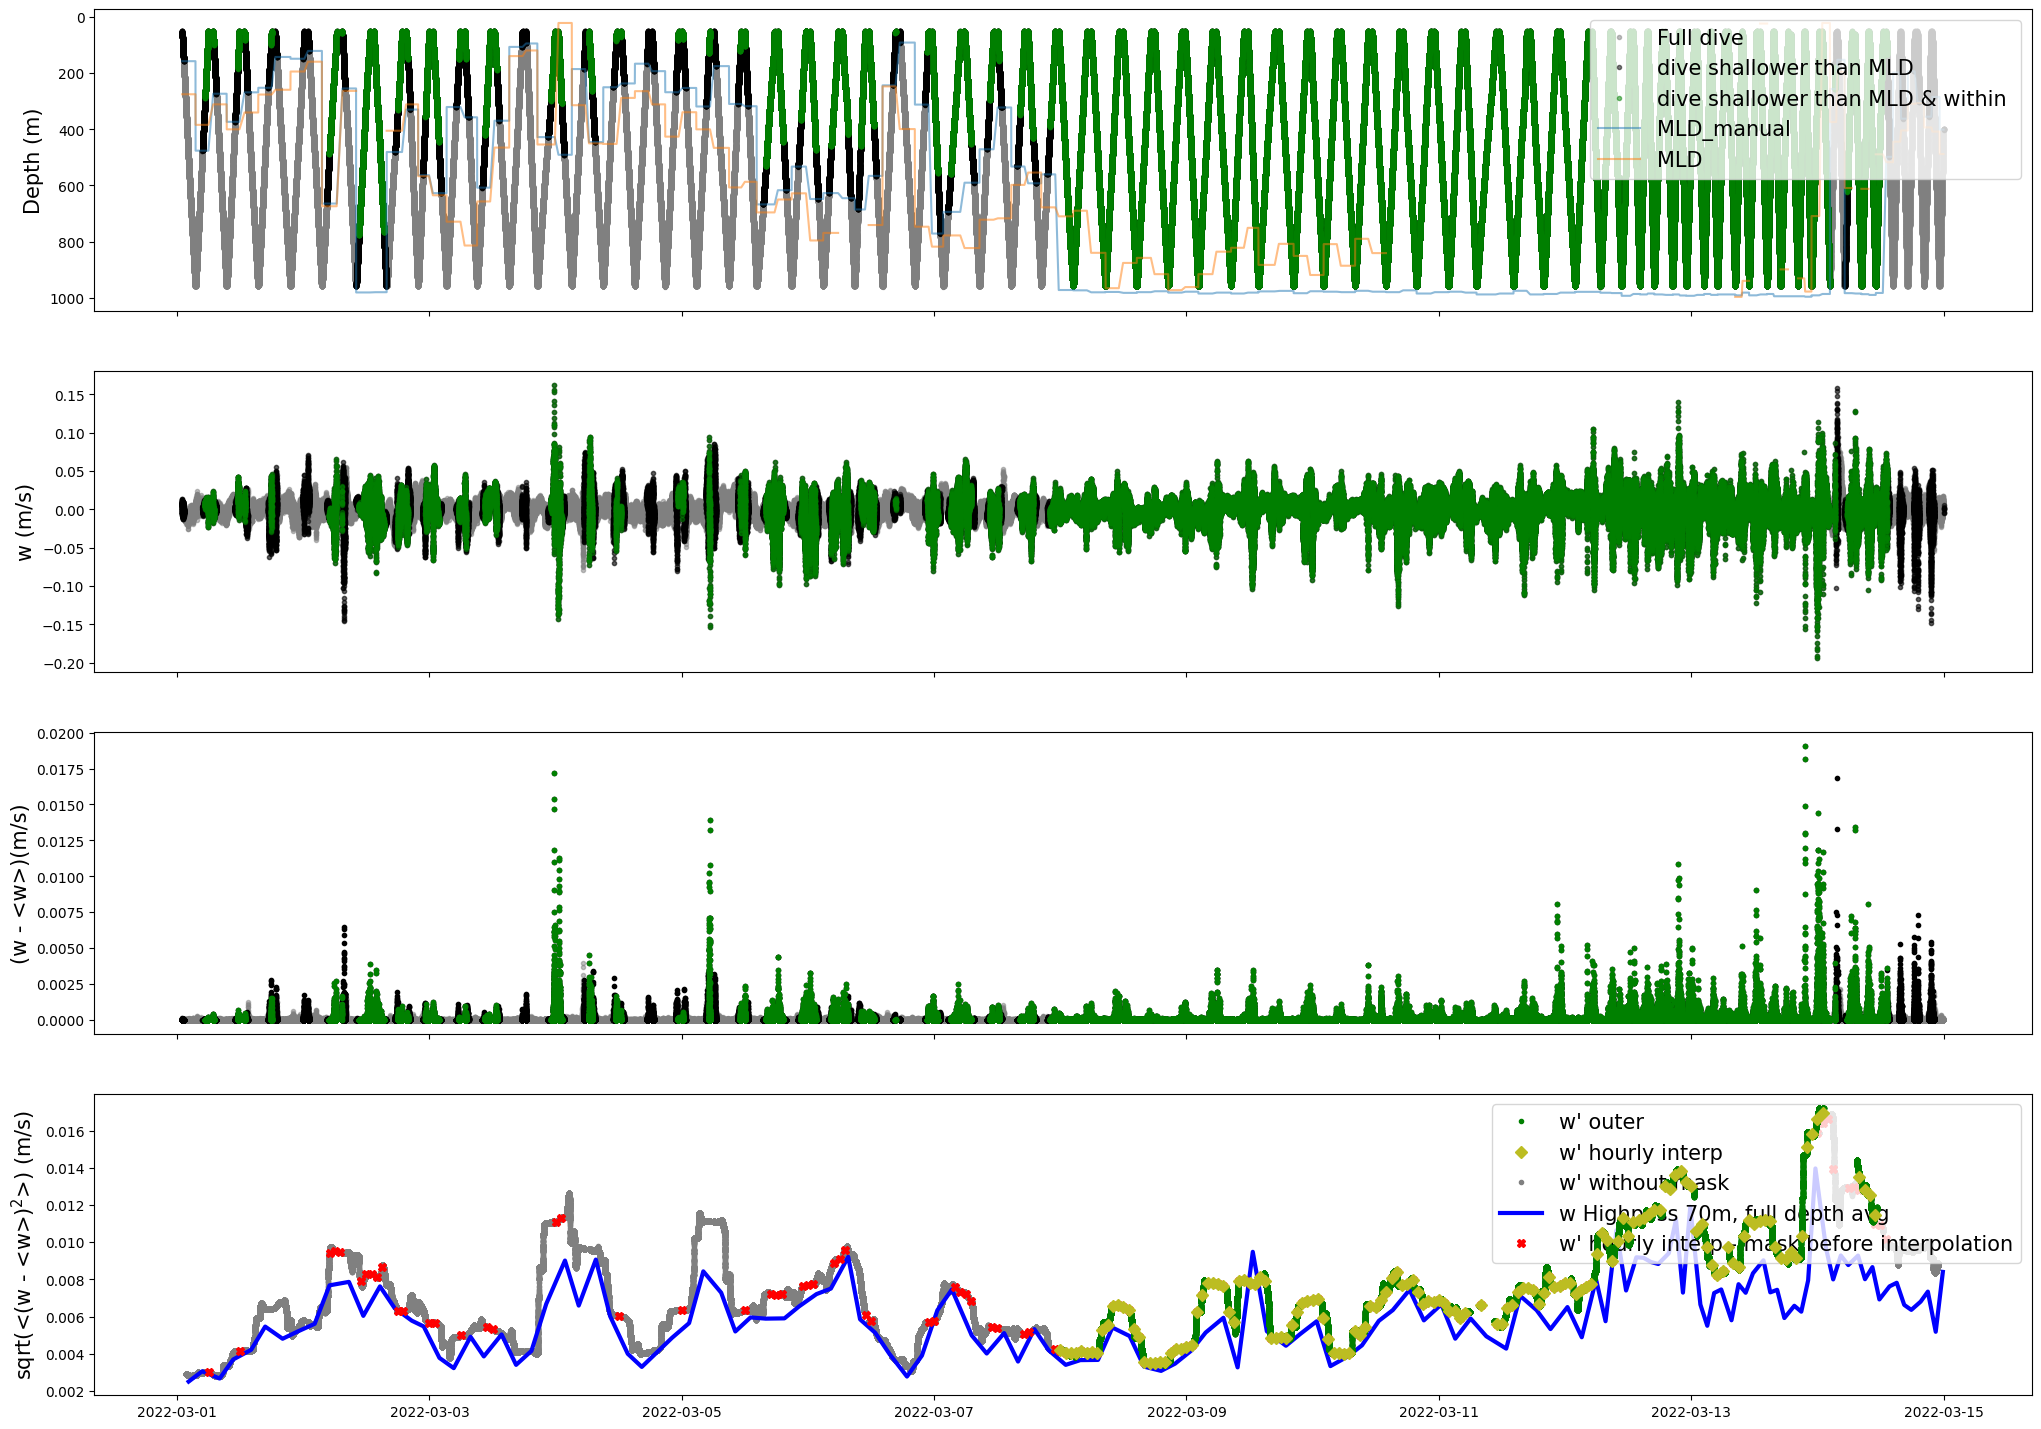

In [9]:
ds_hp_sel = ds_hp.isel({'profile_index' : (ds_hp['mid_times'] >= config['start_time']) & (ds_hp['mid_times'] <= config['end_time'])}, drop=True)
fig, ax = plotters.plot_lag_correlation_steps(intermediates, ds_398, 
                                                   wprime_rms=wprime_rms, 
                                                   series_2 = series_w_prime_masklater, 
                                                   ds_hp = ds_hp_sel,
                                                   mld_var=['MLD_manual','MLD'])
# Set x limit to zoom in
#ax[0].set_xlim(config['start_time'], config['end_time'])
# ax[0].set_xlim(pd.to_datetime('2022-03-05T00:00:00'), pd.to_datetime('2022-03-15T00:00:00'))

## Calculate & Plot time-lag correlations

[range(-72, 73), range(-72, 73)] [[0.25532921656775626, 0.34959566053016944, 0.4359307764120967, 0.5134143952914659, 0.5770544329566407, 0.6242284662795233, 0.6525575155518614, 0.6527048801855344, 0.6399690555259805, 0.6039428297738645, 0.5593955255622235, 0.5023450552309792, 0.43004225875174074, 0.3792255660088089, 0.3384686614036607, 0.324088658891832, 0.3266536888268339, 0.3293388396107697, 0.3392108573711549, 0.34410883952347343, 0.3426108277239079, 0.33883437446708325, 0.3376771942544581, 0.345727618191306, 0.34699594948945445, 0.34838222882018255, 0.3658191977751599, 0.3834765787286157, 0.3976235743207884, 0.4181231251021205, 0.45110433111990433, 0.47954477101483967, 0.5084306769492157, 0.530015786038453, 0.5316043764840988, 0.528238933333437, 0.5312367972760309, 0.5367644012074857, 0.5248416126057021, 0.5139127420817226, 0.522319030934747, 0.5173274080623863, 0.5094440042461421, 0.5035842266090869, 0.501430355721911, 0.49959669944172835, 0.4944045028381555, 0.46982226435027724, 

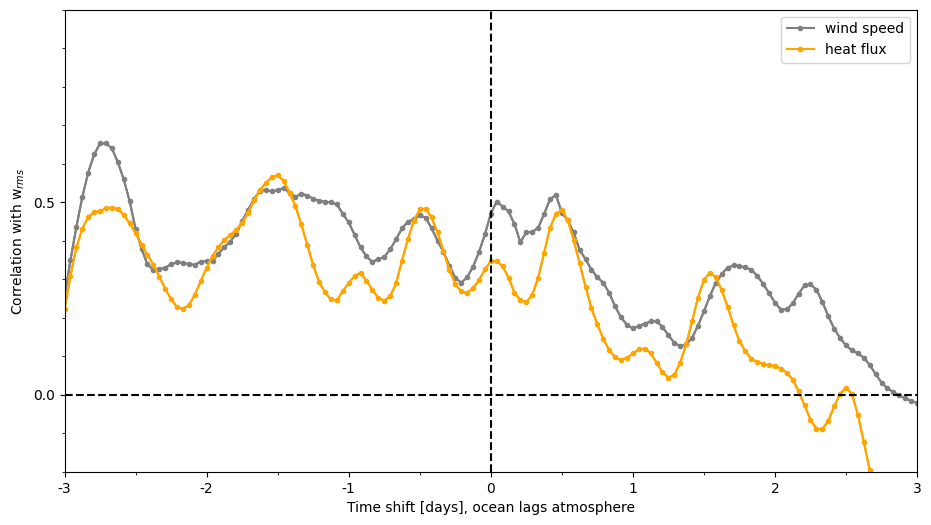

In [12]:
lags_heat, corrs_heat       = tools.lag_correlation(series_w_prime, series_heat, max_lag=config['max_lag'])
lags_wind, corrs_wind       = tools.lag_correlation(series_w_prime, series_wind, max_lag=config['max_lag'])
# Plot the correlation
corr_dict2 = {'lags':            [lags_wind, lags_heat], 
             'correlations':     [corrs_wind, corrs_heat],
             'labels':           ['wind speed', 'heat flux'],}
plot_dict2 = {'ylim':(-0.2,1), 'colors': ['grey','orange'], 'xlim': [-24*3, 24*3]}
fig, ax = plotters.plot_corr(corr_dict2, plot_dict2)

## Plot time series against each other

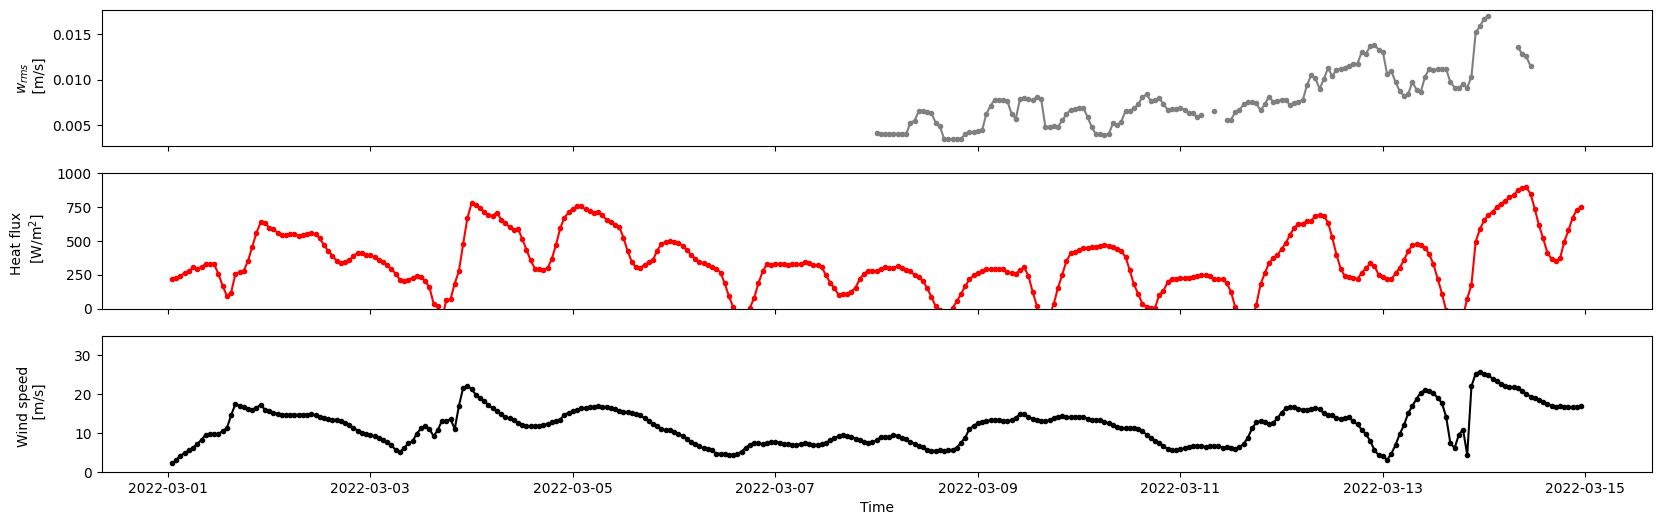

In [13]:
fig, ax = plotters.plot_series_timelag(series_w_prime, series_heat, series_wind)